In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import OrdinalEncoder


from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing  import  OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn.impute import SimpleImputer
from sklearn import compose
from sklearn.model_selection import  cross_val_predict, StratifiedKFold
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config



In [2]:
## load the data
data = pd.read_csv("./dataset_5secondWindow/dataset_5secondWindow.csv", index_col='id')

In [31]:
data.isnull().sum().sort_values(ascending=False).head(20).keys()

Index(['activityrecognition#0', 'android.sensor.step_counter#std',
       'android.sensor.proximity#std', 'android.sensor.proximity#max',
       'android.sensor.proximity#mean', 'android.sensor.proximity#min',
       'android.sensor.pressure#std', 'speed#std',
       'android.sensor.step_counter#mean', 'android.sensor.step_counter#min',
       'android.sensor.step_counter#max', 'android.sensor.pressure#min',
       'android.sensor.pressure#max', 'android.sensor.pressure#mean',
       'android.sensor.light#std', 'speed#mean', 'speed#min', 'speed#max',
       'sound#std', 'android.sensor.light#max'],
      dtype='object')

In [3]:
data.shape

(5893, 70)

In [4]:
df=data.drop('Unnamed: 0', axis=1)

<AxesSubplot:xlabel='target', ylabel='count'>

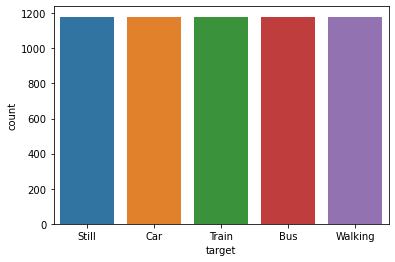

In [5]:
sns.countplot(x ='target', data = df)

<AxesSubplot:xlabel='user', ylabel='count'>

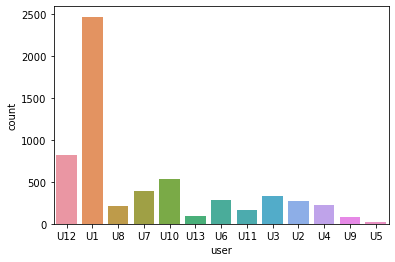

In [6]:
sns.countplot(x='user', data=df)

In [7]:
df = df.dropna(how='all')

In [8]:
df.shape

(5893, 69)

In [9]:
#df=df.dropna()

### Encoding the target

In [10]:
oe = OrdinalEncoder()
cd = df['target'].values
df['target'] = oe.fit_transform(cd.reshape(-1,1))

#### Split the data by grouping by user

In [11]:
def split_data(data: pd.DataFrame, col_select: str, target_name: str)-> pd.DataFrame:
    #ind=data[col_select].value_counts().nlargest().keys()
    user_index=np.array(data[col_select].value_counts().keys())
    df_train=[]
    df_test=[]
    np.random.seed(0)
    for i in range(user_index.shape[0]):
        if user_index[i] == user_index[0]:
            df1=data.loc[data[col_select]==user_index[i]]
            df_train.append(df1)
        else:
            df2=data.loc[data[col_select]==user_index[i]]
            df_test.append(df2)
    x_test=pd.concat(df_test).drop(target_name, axis=1)
    y_test=pd.concat(df_test)[target_name]
    x_train=pd.concat(df_train).drop(target_name, axis=1)
    y_train=pd.concat(df_train)[target_name]

    
    return x_train, x_test, y_train, y_test

id
16170    2.0
15871    1.0
16811    2.0
15831    1.0
15268    0.0
Name: target, dtype: float64

In [12]:
x_train, x_test, y_train, y_test=split_data(df, col_select='user', target_name='target')

In [25]:
x_test.shape

(3423, 67)

In [24]:
x_train.shape

(2470, 67)

In [15]:
x_train=x_train.drop('user', axis=1)
x_test=x_test.drop('user', axis=1)

In [16]:
#cat_vars  = df.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = x_train.select_dtypes(exclude=[object]).columns.values.tolist()


In [17]:
num_4_treeModels = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
  ])

# cat_4_treeModels= Pipeline(steps=[
#   ('imputer,', SimpleImputer( strategy='most_frequent')),
#   ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
#   ])
  
# tree_prepro = compose.ColumnTransformer(transformers=[
#   ('num', num_4_treeModels, num_vars),
#   #('cat', cat_4_treeModels, cat_vars),
#   ], remainder='drop') 
# tree_prepro

In [18]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [19]:
tree_classifiers = {  #"SVC":         SVC(),
                    "Extra Trees":   ExtraTreesClassifier(),
                    "Random Forest": RandomForestClassifier(),
                    "AdaBoost":      AdaBoostClassifier(),
                    "Skl GBM":       GradientBoostingClassifier(),
                    "Logistic_reg":  LogisticRegression(),
                    "LightGBM":      KNeighborsClassifier(),
                    
                   
                    }

tree_classifiers = {name: pipeline.make_pipeline(num_4_treeModels, model) for name, model in tree_classifiers.items()}

In [20]:
results = pd.DataFrame({'Model': [], 'Accuracy': [],  'Time': []})


for model_name, model in tree_classifiers.items():
    start_time = time.time()
    
    # FOR EVERY PIPELINE (PREPRO + MODEL) -> TRAIN WITH TRAIN DATA (x_train)
    model.fit(x_train, y_train)
    # GET PREDICTIONS USING x_val
    pred = model.predict(x_test)

    total_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": accuracy_score(y_test, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)


C:\Users\KINGSLEY\AppData\Local\Temp\ipykernel_16572\3672655609.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\KINGSLEY\AppData\Local\Temp\ipykernel_16572\3672655609.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\KINGSLEY\AppData\Local\Temp\ipykernel_16572\3672655609.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\KINGSLEY\AppData\Local\Temp\ipykernel_16572\3672655609.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({

In [21]:
results

,Model,Accuracy,Time
0,Extra Trees,16.681274,2.742663
1,Random Forest,18.229623,5.261882
2,AdaBoost,22.085890,4.139917
3,Skl GBM,24.802805,74.910496
4,Logistic_reg,19.894829,3.925545
5,LightGBM,16.213848,2.755625
